In [1]:
# Source https://link.springer.com/chapter/10.1007/978-90-481-3702-2_5

#function [u,lam,v,proj]=combeof(zz,inds,indz,nmode,nproj)
# %
# % Compute combined EOF of matrix zz. The matrix zz contains
# % the ordered fields to be combined, in this case Z and S.
# % Inputs:
# % zz Combined Data Matrix
# % inds Index for the S data (ocean)
# % indz Index for the Z data (atmosphere)
# % nmode Number of EOF to return
# % nproj Number of EOF to generate projections
# % Outputs:
# % u EOF arrays (nspace x nmode)
# % lam variance explained (ntime)
# % v Unnormalized EOF coefficients
# % proj Projection on the nmode EOF
# resol = [96 48]; ss=resol(1)*resol(2);
# [uu,ss,vv]=svd(zz,0);
# lam = diag(ss).ˆ2/sum(diag(ss).ˆ2); % Explained variances
# ls=length(inds); lz=length(indz);
# u=zeros([ss nmode]); v=zeros([ss nmode]);
# for i=1:nmode
# u(indz,i)=uu(1:lz,i);
# v(inds,i)=uu(lz+1:lz+ls,i);
# end
# proj=zz*uu(:,1:nproj); % Compute projections
# return

In [2]:
# The only task then is to make a combined matrix after that a normal eof can be done

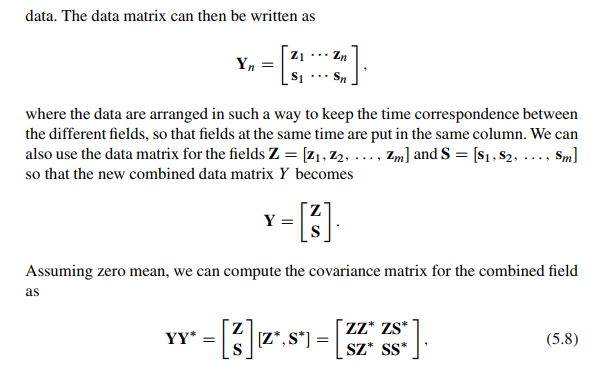

In [3]:
%matplotlib inline

import os
import time

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

from mpl_toolkits.basemap import Basemap

import netCDF4 as nc

from six.moves import urllib # six is for Python 2/3 compatibility

from pycurrents.codas import to_day
from pycurrents.num import rangeslice
from pycurrents.num import eof

In [4]:
#sstnc  = nc.Dataset('sst_yrmean_1951_2124_remap_ind.nc')
#tauxnc = nc.Dataset('esm_pi_taux_1951_2124_ind.nc')
#tauync = nc.Dataset('esm_pi_tauy_1951_2124_ind.nc')
sstnc = nc.Dataset('sst.mnmean.nc')

In [5]:

# Read all the 1-D dimensional arrays.
time = sstnc.variables['time'][:]
lat = sstnc.variables['lat'][:]                       
lon = sstnc.variables['lon'][:]
sst = sstnc.variables['sst'][:]

In [6]:
sst  = np.ma.masked_array(sst, np.isnan(sst))
#aux = np.ma.masked_array(taux, np.isnan(taux))
#tauy = np.ma.masked_array(tauy, np.isnan(tauy))

In [7]:
sst.shape

(442, 180, 360)

In [9]:
X_sst  = np.reshape(sst, (sst.shape[0], sst.shape[1] * sst.shape[2]), order='F')
X_taux = np.reshape(taux, (taux.shape[0], taux.shape[1] * taux.shape[2]), order='F')
X_tauy = np.reshape(tauy, (taux.shape[0], tauy.shape[1] * tauy.shape[2]), order='F')

In [10]:
X_sst_norm = (X_sst - np.mean(X_sst,axis=0))
X_taux_norm = X_taux - np.mean(X_taux,axis=0)
X_tauy_norm = X_tauy - np.mean(X_tauy,axis=0)

In [11]:
X = np.zeros((X_sst.shape[0]*3, X_sst.shape[1]))

In [12]:
X[0:X_sst.shape[0],:]                = X_sst_norm
X[X_sst.shape[0]:2*X_sst.shape[0],:] = X_taux_norm
X[2*X_sst.shape[0]:3*X_sst.shape[0],:] = X_tauy_norm

In [13]:
covX = np.dot(X.T, X) / X.shape[0]

In [14]:
vals, vecs = np.linalg.eig(covX)

In [15]:
isort = np.argsort(vals)[::-1]
vals = vals[isort]    # Eigen Values
vecs = vecs[:, isort] # EOFs/eigen vectors
pc_number = 0
eof_number = 0

eof = vecs[eof_number, :]
tvecs = np.dot(X, vecs[pc_number, :]) # PCs

In [16]:
# Sanity check 
print(tvecs.shape)
print(vecs.shape)
print(vals.shape)
print(X.shape)
print(eof.shape)

(522,)
(2840, 2840)
(2840,)
(522, 2840)
(2840,)


In [25]:
cmap = plt.get_cmap('RdBu_r')
n_eofs = 4
eof_2d_n = np.zeros((n_eofs, sst.shape[1] , sst.shape[2]))
for i in range(n_eofs):
    eof_2d = np.reshape(vecs[n_eofs, :], (sst.shape[1] , sst.shape[2]))
    eof_2d_n[i,:,:] = eof_2d


/home/manmeet/anaconda3/envs/py35/lib/python3.5/site-packages/ipykernel_launcher.py:6: ComplexWarning: Casting complex values to real discards the imaginary part
  


In [18]:
# percentage of variance explained 
print("Percentage of variance explained by first EOF = ",np.around(np.absolute(vals[0]/np.sum(vals))))
print("Percentage of variance explained by second EOF = ",np.around(np.absolute(vals[1]/np.sum(vals))))

Percentage of variance explained by first EOF =  1.0
Percentage of variance explained by second EOF =  0.0


In [150]:
def writeFile(nlat, nlon, outfilename):
    location = (outfilename)
    dataset = nc.Dataset(location,'w',format='NETCDF4')
    lats = dataset.createDimension('latitude', nlat )
    lons = dataset.createDimension('longitude', nlon)
    return dataset


In [154]:
dataset = writeFile(sst.shape[1], sst.shape[2], "eof.nc")
lats = dataset.createVariable('latitude', 'f4',('latitude'))
lons = dataset.createVariable('longitude', 'f4',('longitude'))
eofs = dataset.createVariable('eof1', np.float32,('latitude', 'longitude'), fill_value=0.0)

lats.standard_name = 'latitude'
lats.long_name = 'latitude'
lats.units = 'degrees_north'
lats.axis = 'Y'

lons.standard_name = 'longitude'
lons.long_name = 'longitude'
lons.units = 'degrees_east'
lons.axis = 'X'
lats[:]  = lat
lons[:]  = lon
eofs[:] = eof_2d


/home/manmeet/anaconda3/envs/py35/lib/python3.5/site-packages/ipykernel_launcher.py:17: ComplexWarning: Casting complex values to real discards the imaginary part


In [19]:
gmap = Basemap(lon_0=80, projection="kav7", resolution='c')
X, Y = gmap(*np.meshgrid(lon, lat))
def draw_map(gmap, ax):
    gmap.drawmapboundary(ax=ax)
    gmap.drawcoastlines(ax=ax)
    gmap.fillcontinents(ax=ax)
    gmap.drawmeridians(np.arange(0, 360.01, 30), ax=ax)
    gmap.drawparallels(np.arange(-60, 60.01, 30), ax=ax)


In [20]:
mag = eof_2d.std()
cticker = mpl.ticker.MaxNLocator(nbins=30, symmetric=True)
cticker.create_dummy_axis()
#cticker.set_bounds(-2*mag, 2*mag)
clevs = cticker()


/home/manmeet/.local/lib/python3.5/site-packages/numpy/ma/core.py:2785: ComplexWarning: Casting complex values to real discards the imaginary part
  order=order, subok=True, ndmin=ndmin)


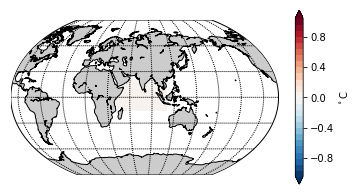

In [21]:
cmap = plt.get_cmap('RdBu_r')
fig, ax = plt.subplots()
draw_map(gmap, ax=ax)
cs = gmap.contourf(X, Y, eof_2d, levels=clevs, cmap=cmap, extend='both', ax=ax)
cbar = fig.colorbar(cs, ax=ax, orientation='vertical',
                        shrink=0.8,
                        ticks=plt.MaxNLocator(nbins=6, symmetric=True))
cbar.set_label('$^\circ$C')

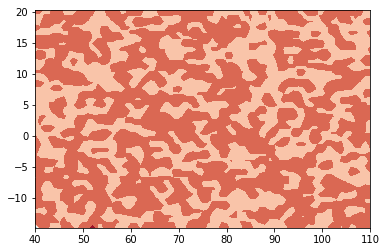

In [29]:
plt.contourf(lon, lat, np.real(eof_2d), cmap=cmap)